In [1]:
# Install PyTorch
!pip install torch tensorboard

# Install Hugging Face libraries
!pip install transformers datasets accelerate evaluate bitsandbytes huggingface_hub trl peft matplotlib scikit-learn seaborn


[notice] A new release of pip is available: 23.3.1 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip is available: 23.3.1 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip


In [2]:
import os
import random
import functools
import csv
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
import evaluate
from datasets import Dataset, load_dataset
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix, classification_report, balanced_accuracy_score, accuracy_score

from datasets import Dataset, DatasetDict
from peft import LoraConfig, prepare_model_for_kbit_training, get_peft_model
import os
import torch
from datasets import load_dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    AutoTokenizer,
    TrainingArguments,
    pipeline,
)
from peft import LoraConfig, PeftModel, prepare_model_for_kbit_training
from trl import SFTTrainer

In [3]:
# Load the SNLI dataset from Hugging Face
snli = load_dataset('snli')

# Function to select samples as described
def select_samples(dataset, total_samples, step):
    indices = list(range(0, total_samples, step))
    return dataset.select(indices)

# Select samples for training, validation, and test
train_data = select_samples(snli['train'], 550000, 550)
validation_data = select_samples(snli['validation'], 10000, 100)
test_data = select_samples(snli['test'], 10000, 100)


/tmp/ipykernel_1800/218134254.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=counts, palette="viridis")


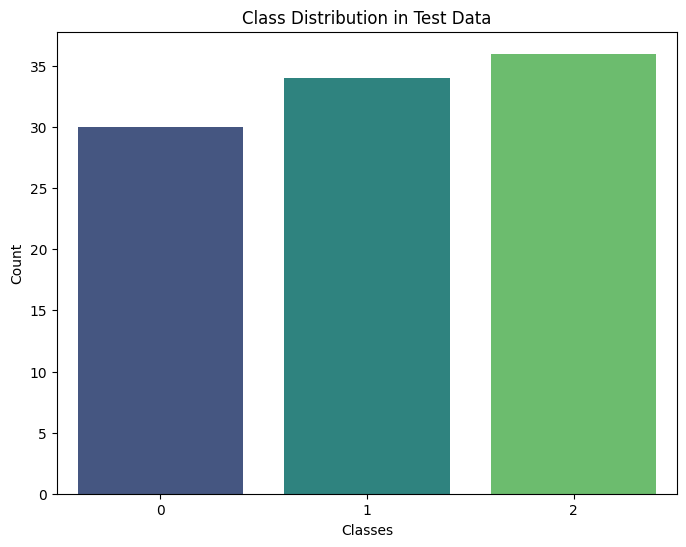

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Count occurrences of each label in the dataset
label_counts = Counter(test_data["label"])  # Replace with the appropriate column for labels if different

# Extract labels and counts
labels = list(label_counts.keys())
counts = list(label_counts.values())

# Plotting the distribution
plt.figure(figsize=(8, 6))
sns.barplot(x=labels, y=counts, palette="viridis")
plt.xlabel("Classes")
plt.ylabel("Count")
plt.title("Class Distribution in Test Data")
plt.show()


In [8]:
train_data[0]

{'premise': 'A person on a horse jumps over a broken down airplane.',
 'hypothesis': 'A person is training his horse for a competition.',
 'label': 1}

In [9]:
mapping = {'entailment': 0, 'neutral': 1, 'contradiction': 2}

In [5]:
# from datasets import Dataset

# # Define the prompt generation function
# def formatting_func(example):
#     prompt = (
#         f"Task: Recognize Textual Entailment\n"
#         f"Premise: \"{example['premise']}\"\n"
#         f"Hypothesis: \"{example['hypothesis']}\"\n"
#         f"Question: Based on the premise, does the hypothesis entail, contradict, or is it neutral with respect to the premise?\n"
#         f"Options:\n"
#         f"0: entailment\n"
#         f"1: neutral\n"
#         f"2: contradiction\n"
#         f"Please select the correct option number."
#     )
#     return prompt

# # Preprocessing function to format the data
# def preprocess_function(dataframe):
#     inputs = []
#     targets = []
#     for i in range(dataframe.shape[0]):
#         # Use the formatting function to generate the prompt
#         input_text = formatting_func({
#             'premise': dataframe['premise'][i],
#             'hypothesis': dataframe['hypothesis'][i]
#         })
        
#         # Target text is the label mapped to string format
#         target_text = str(dataframe['label'][i])
        
#         # Append to the lists
#         inputs.append(input_text)
#         targets.append(target_text)
    
#     # Return as a dictionary suitable for Dataset creation
#     return {"inputs": inputs, "targets": targets}

# # Apply preprocessing and convert to Dataset
# train_data_p = Dataset.from_dict(preprocess_function(train_data))       # For training
# eval_data_p = Dataset.from_dict(preprocess_function(validation_data))   # For validation
# test_data_p = Dataset.from_dict(preprocess_function(test_data))         # For testing

# # Optionally, print a sample to verify
# print("Sample Training Data:", train_data_p[0])
# print("Sample Validation Data:", eval_data_p[0])
# print("Sample Testing Data:", test_data_p[0])


Sample Training Data: {'inputs': 'Task: Recognize Textual Entailment\nPremise: "A person on a horse jumps over a broken down airplane."\nHypothesis: "A person is training his horse for a competition."\nQuestion: Based on the premise, does the hypothesis entail, contradict, or is it neutral with respect to the premise?\nOptions:\n0: entailment\n1: neutral\n2: contradiction\nPlease select the correct option number.', 'targets': '1'}
Sample Validation Data: {'inputs': 'Task: Recognize Textual Entailment\nPremise: "Two women are embracing while holding to go packages."\nHypothesis: "The sisters are hugging goodbye while holding to go packages after just eating lunch."\nQuestion: Based on the premise, does the hypothesis entail, contradict, or is it neutral with respect to the premise?\nOptions:\n0: entailment\n1: neutral\n2: contradiction\nPlease select the correct option number.', 'targets': '1'}
Sample Testing Data: {'inputs': 'Task: Recognize Textual Entailment\nPremise: "This church ch

In [26]:
from datasets import Dataset

# Define the prompt generation function
def formatting_func(example):
    prompt = (
        f"Task: Recognize Textual Entailment\n"
        f"Premise: \"{example['premise']}\"\n"
        f"Hypothesis: \"{example['hypothesis']}\"\n"
        f"Question: Based on the premise, does the hypothesis entail, contradict, or is it neutral with respect to the premise?\n"
        f"Options:\n"
        f"0: entailment\n"
        f"1: neutral\n"
        f"2: contradiction\n"
        f"Please select the correct option number."
    )
    return prompt

# Preprocessing function to format the data into a single prompt with target included
def preprocess_function(dataframe):
    prompts = []
    for i in range(dataframe.shape[0]):
        # Use the formatting function to generate the prompt
        input_text = formatting_func({
            'premise': dataframe['premise'][i],
            'hypothesis': dataframe['hypothesis'][i]
        })
        
        # Append the target label to the prompt as the answer
        target_text = str(dataframe['label'][i])
        prompt_with_answer = f"{input_text}\nAnswer: {target_text}"
        
        # Append to the list
        prompts.append(prompt_with_answer)
    
    # Return as a dictionary suitable for Dataset creation
    return {"text": prompts}

# Apply preprocessing and convert to Dataset
train_data_p = Dataset.from_dict(preprocess_function(train_data))       # For training
eval_data_p = Dataset.from_dict(preprocess_function(validation_data))   # For validation
test_data_p = Dataset.from_dict(preprocess_function(test_data))         # For testing

# Optionally, print a sample to verify
print("Sample Training Data:", train_data_p[0])
print("Sample Validation Data:", eval_data_p[0])
print("Sample Testing Data:", test_data_p[0])


Sample Training Data: {'text': 'Task: Recognize Textual Entailment\nPremise: "A person on a horse jumps over a broken down airplane."\nHypothesis: "A person is training his horse for a competition."\nQuestion: Based on the premise, does the hypothesis entail, contradict, or is it neutral with respect to the premise?\nOptions:\n0: entailment\n1: neutral\n2: contradiction\nPlease select the correct option number.\nAnswer: 1'}
Sample Validation Data: {'text': 'Task: Recognize Textual Entailment\nPremise: "Two women are embracing while holding to go packages."\nHypothesis: "The sisters are hugging goodbye while holding to go packages after just eating lunch."\nQuestion: Based on the premise, does the hypothesis entail, contradict, or is it neutral with respect to the premise?\nOptions:\n0: entailment\n1: neutral\n2: contradiction\nPlease select the correct option number.\nAnswer: 1'}
Sample Testing Data: {'text': 'Task: Recognize Textual Entailment\nPremise: "This church choir sings to the

In [11]:
test_data_p[0]

{'inputs': 'Task: Recognize Textual Entailment\nPremise: "This church choir sings to the masses as they sing joyous songs from the book at a church."\nHypothesis: "The church has cracks in the ceiling."\nQuestion: Based on the premise, does the hypothesis entail, contradict, or is it neutral with respect to the premise?\nOptions:\n0: entailment\n1: neutral\n2: contradiction\nPlease select the correct option number.',
 'targets': '1'}

In [6]:
model_name = "microsoft/phi-2"
compute_dtype = torch.float16

# Quantization config
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=False,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=compute_dtype,
)

model = AutoModelForCausalLM.from_pretrained(model_name, quantization_config=bnb_config, device_map="auto")


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [13]:
import warnings

# Suppress specific warning message
warnings.filterwarnings("ignore", message="Setting `pad_token_id` to `eos_token_id`: None for open-end generation.")


In [18]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from sklearn.metrics import confusion_matrix, classification_report, balanced_accuracy_score, accuracy_score
from tqdm import tqdm

tokenizer = AutoTokenizer.from_pretrained(model_name, add_prefix_space=True)

# Ensure both pad_token_id and eos_token_id are set in tokenizer and model
tokenizer.pad_token_id = tokenizer.eos_token_id
tokenizer.pad_token = tokenizer.eos_token

# Explicitly set these in the model configuration to avoid warnings
model.config.pad_token_id = tokenizer.pad_token_id
model.config.eos_token_id = tokenizer.eos_token_id


# Define the performance metrics function
def get_performance_metrics(actual, predicted):
    actual = list(map(str, actual))
    predicted = list(map(str, predicted))
    print("Confusion Matrix:")
    print(confusion_matrix(actual, predicted))
    print("\nClassification Report:")
    print(classification_report(actual, predicted))
    print("Balanced Accuracy Score:", balanced_accuracy_score(actual, predicted))
    print("Accuracy Score:", accuracy_score(actual, predicted))

# Function to generate predictions with error handling
def generate_prediction(model, tokenizer, premise, hypothesis):
    try:
        prompt = (
            f"Task: Recognize Textual Entailment\n"
            f"Premise: \"{premise}\"\n"
            f"Hypothesis: \"{hypothesis}\"\n"
            f"Question: Based on the premise, does the hypothesis entail, contradict, or is it neutral with respect to the premise?\n"
            f"Options:\n0: entailment\n1: neutral\n2: contradiction\nPlease select the correct option number.\nAnswer:"
        )
        inputs = tokenizer(prompt, return_tensors="pt", padding=True).to(model.device)
        output = model.generate(**inputs, max_length=150)
        generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
        
        # Extract answer from model output and ensure it's one of "0", "1", or "2"
        answer = generated_text.split("Answer:")[-1].strip().split()[0]  # Get the first word after "Answer:"
        if answer in {"0:", "0"}:
            return "0"
        elif answer in {"1:", "1"}:
            return "1"
        elif answer in {"2:", "2"}:
            return "2"
        else:
            return "unknown"  # Fallback for unexpected output
    except Exception as e:
        print(f"Error in prediction: {e}")
        return "unknown"

# Run evaluation on the test data with tqdm for progress
actual_labels = []
predicted_labels = []

for sample in tqdm(test_data_p, desc="Processing test samples"):
    premise = sample['inputs'].split('Premise: "')[-1].split('"')[0]
    hypothesis = sample['inputs'].split('Hypothesis: "')[-1].split('"')[0]
    actual = sample['targets']
    
    # Generate prediction
    predicted = generate_prediction(model, tokenizer, premise, hypothesis)
    
    # Only consider valid predictions
    if predicted in {"0", "1", "2"}:
        actual_labels.append(actual)
        predicted_labels.append(predicted)

# Evaluate model performance only on valid predictions
get_performance_metrics(actual_labels, predicted_labels)


Processing test samples: 100%|██████████| 100/100 [04:52<00:00,  2.92s/it]

Confusion Matrix:
[[26  0  0]
 [33  0  0]
 [30  0  5]]

Classification Report:
              precision    recall  f1-score   support

           0       0.29      1.00      0.45        26
           1       0.00      0.00      0.00        33
           2       1.00      0.14      0.25        35

    accuracy                           0.33        94
   macro avg       0.43      0.38      0.23        94
weighted avg       0.45      0.33      0.22        94

Balanced Accuracy Score: 0.38095238095238093
Accuracy Score: 0.32978723404255317



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [7]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=32,
    lora_alpha=64,
    target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        "gate_proj",
        "up_proj",
        "down_proj",
        "lm_head",
    ],
    bias="none",
    lora_dropout=0.05,  # Conventional
    task_type="CAUSAL_LM",
)

model = get_peft_model(model, config)

In [20]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

In [29]:
print_trainable_parameters(model)

trainable params: 17448960 || all params: 1538841600 || trainable%: 1.1339022807805559


In [8]:
from peft import prepare_model_for_kbit_training

model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

In [31]:
print(model)

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): PhiForCausalLM(
      (model): PhiModel(
        (embed_tokens): Embedding(51200, 2560)
        (embed_dropout): Dropout(p=0.0, inplace=False)
        (layers): ModuleList(
          (0-31): 32 x PhiDecoderLayer(
            (self_attn): PhiAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=2560, out_features=2560, bias=True)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=2560, out_features=32, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=32, out_features=2560, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict(

In [9]:
tokenizer = AutoTokenizer.from_pretrained(model_name, add_prefix_space=True)

tokenizer.pad_token_id = tokenizer.eos_token_id
tokenizer.pad_token = tokenizer.eos_token

In [10]:
model.config.pad_token_id = tokenizer.pad_token_id
model.config.use_cache = False
model.config.pretraining_tp = 1

# Finetunning phi-2 on stanfordnlp/snli dataset

In [11]:
from accelerate import Accelerator

# Initialize Accelerator
accelerator = Accelerator()

# Prepare model using accelerator
model = accelerator.prepare_model(model)


In [12]:
# Define the tokenization function
def tokenize_function(example):
    # Tokenize the inputs and targets separately
    inputs = tokenizer(
        example["inputs"],
        padding="max_length",
        truncation=True,
        max_length=None,  # Set max length based on model requirements
        return_tensors="pt"
    )
    targets = tokenizer(
        example["targets"],
        padding="max_length",
        truncation=True,
        max_length=None,  # Set max length for target based on label size
        return_tensors="pt"
    )
    
    # Renaming labels for the format needed in transformers
    labels = targets["input_ids"]
    
    # Return as dictionary including inputs and labels for the model
    return {
        "input_ids": inputs["input_ids"].squeeze(),
        "attention_mask": inputs["attention_mask"].squeeze(),
        "labels": labels.squeeze()
    }

# Apply tokenization on train, validation, and test data
train_data_tokenized = train_data_p.map(tokenize_function, batched=True)
eval_data_tokenized = eval_data_p.map(tokenize_function, batched=True)

# Optionally, set the format for PyTorch tensors
train_data_tokenized.set_format(type="torch")
eval_data_tokenized.set_format(type="torch")

# Check sample from tokenized data
print("Sample Tokenized Training Data:", train_data_tokenized[0])
print("Sample Tokenized Validation Data:", eval_data_tokenized[0])


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Sample Tokenized Training Data: {'inputs': 'Task: Recognize Textual Entailment\nPremise: "A person on a horse jumps over a broken down airplane."\nHypothesis: "A person is training his horse for a competition."\nQuestion: Based on the premise, does the hypothesis entail, contradict, or is it neutral with respect to the premise?\nOptions:\n0: entailment\n1: neutral\n2: contradiction\nPlease select the correct option number.', 'targets': '1', 'input_ids': tensor([15941,    25, 31517,  ..., 50256, 50256, 50256]), 'attention_mask': tensor([1, 1, 1,  ..., 0, 0, 0]), 'labels': tensor([  352, 50256, 50256,  ..., 50256, 50256, 50256])}
Sample Tokenized Validation Data: {'inputs': 'Task: Recognize Textual Entailment\nPremise: "Two women are embracing while holding to go packages."\nHypothesis: "The sisters are hugging goodbye while holding to go packages after just eating lunch."\nQuestion: Based on the premise, does the hypothesis entail, contradict, or is it neutral with respect to the premis

In [34]:
# Set training arguments
training_arguments = TrainingArguments(
    output_dir = "/root/model",
    num_train_epochs = 5,
    fp16 = False,
    bf16 = False,
    per_device_train_batch_size = 64,
    per_device_eval_batch_size = 4,
    gradient_accumulation_steps = 1,
    gradient_checkpointing = True,
    max_grad_norm = 0.3,
    learning_rate = 2e-4,
    weight_decay = 0.001,
    optim = "paged_adamw_32bit",
    lr_scheduler_type = "cosine",
    max_steps = -1,
    warmup_ratio = 0.03,
    group_by_length = True,
    save_steps = 16,
    logging_steps = 16,
)

In [35]:
# Set supervised fine-tuning parameters
trainer = SFTTrainer(
    model=model,
    train_dataset=train_data_p,
    eval_dataset=eval_data_p,
    dataset_text_field="text",
    max_seq_length= None,
    tokenizer=tokenizer,
    args=training_arguments,
)

# Train model
trainer.train()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': dataset_text_field. Will not be supported from version '0.13.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:309: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:328: UserWarning: You passed a `dataset_text_field` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Step,Training Loss
16,2.429600
32,2.427700
48,2.427000
64,2.429200
80,2.427600


/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:227: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:227: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:227: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:227: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers fou

TrainOutput(global_step=80, training_loss=2.4282390117645263, metrics={'train_runtime': 590.1212, 'train_samples_per_second': 8.473, 'train_steps_per_second': 0.136, 'total_flos': 8418950779699200.0, 'train_loss': 2.4282390117645263, 'epoch': 5.0})

#Inference on finetunemodel

In [2]:
import os
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from sklearn.metrics import confusion_matrix, classification_report, balanced_accuracy_score, accuracy_score
from tqdm import tqdm

# Model directory and specific checkpoint
checkpoint_path = "/root/model/checkpoint-80"

# Load the tokenizer from the specific checkpoint
tokenizer = AutoTokenizer.from_pretrained(checkpoint_path, add_prefix_space=True)

# Ensure pad_token_id and eos_token_id are set
tokenizer.pad_token_id = tokenizer.eos_token_id
tokenizer.pad_token = tokenizer.eos_token

# Define performance metrics function
def get_performance_metrics(actual, predicted):
    actual = list(map(str, actual))
    predicted = list(map(str, predicted))
    print("Confusion Matrix:")
    print(confusion_matrix(actual, predicted))
    print("\nClassification Report:")
    print(classification_report(actual, predicted))
    print("Balanced Accuracy Score:", balanced_accuracy_score(actual, predicted))
    print("Accuracy Score:", accuracy_score(actual, predicted))

# Prediction generation function
def generate_prediction(model, tokenizer, premise, hypothesis):
    try:
        prompt = (
            f"Task: Recognize Textual Entailment\n"
            f"Premise: \"{premise}\"\n"
            f"Hypothesis: \"{hypothesis}\"\n"
            f"Question: Based on the premise, does the hypothesis entail, contradict, or is it neutral with respect to the premise?\n"
            f"Options:\n0: entailment\n1: neutral\n2: contradiction\nPlease select the correct option number.\nAnswer:"
        )
        inputs = tokenizer(prompt, return_tensors="pt", padding=True).to(model.device)
        output = model.generate(**inputs, max_length=150)
        generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
        
        # Extract answer from model output
        answer = generated_text.split("Answer:")[-1].strip().split()[0]
        if answer in {"0:", "0"}:
            return "0"
        elif answer in {"1:", "1"}:
            return "1"
        elif answer in {"2:", "2"}:
            return "2"
        else:
            return "unknown"  # Fallback for unexpected output
    except Exception as e:
        print(f"Error in prediction: {e}")
        return "unknown"

# Load the model from the specific checkpoint
print(f"\nEvaluating checkpoint: {checkpoint_path}")
model = AutoModelForCausalLM.from_pretrained(checkpoint_path).to("cuda" if torch.cuda.is_available() else "cpu")
model.config.pad_token_id = tokenizer.pad_token_id
model.config.eos_token_id = tokenizer.eos_token_id
model.eval()

# Run evaluation on the test data
actual_labels = []
predicted_labels = []

for sample in tqdm(test_data_p, desc=f"Processing test samples for {checkpoint_path}"):
    premise = sample['inputs'].split('Premise: "')[-1].split('"')[0]
    hypothesis = sample['inputs'].split('Hypothesis: "')[-1].split('"')[0]
    actual = sample['targets']
    
    # Generate prediction
    predicted = generate_prediction(model, tokenizer, premise, hypothesis)
    
    # Only consider valid predictions
    if predicted in {"0", "1", "2"}:
        actual_labels.append(actual)
        predicted_labels.append(predicted)

# Evaluate model performance for this checkpoint
print(f"\nPerformance metrics for checkpoint: {checkpoint_path}")
get_performance_metrics(actual_labels, predicted_labels)

# Clear model from memory
del model
torch.cuda.empty_cache()
